In [ ]:
!pip install git+http://hf.co/usm3d/tools.git    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PerspectiveCameras
)
from pytorch3d.structures import Pointclouds

In [3]:
import webdataset as wds 
import numpy as np
from huggingface_hub import hf_hub_download
from hoho import proc
from tqdm import tqdm
import sys
sys.path.append('..')
import trimesh
import hoho
from hoho import *
from hoho.vis import line
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm
from hoho.viz3d import plot_estimate_and_gt

from my_solution import *
from helpers import *

In [4]:
import huggingface_hub  
huggingface_hub.login()

# Loading part of training data

For simplicity we are showing example only on a once shard of data

In [5]:
from hoho.read_write_colmap import read_cameras_binary, read_images_binary, read_points3D_binary
all_pclouds = []
all_verts = []
for i in tqdm(range(1, 25)):
    dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
            filename=f'data/train/hoho_v3_{str(i).zfill(3)}-of-032.tar.gz',
            repo_type="dataset"))
    dataset = dataset.decode()
    dataset = dataset.map(proc)

    for ki, entry in enumerate(dataset):
        points3d = read_points3D_binary(fid=io.BytesIO(entry['points3d']))
        xyz = np.stack([p.xyz for p in points3d.values()])
        all_pclouds.append(xyz)
        all_verts.append(entry["wf_vertices"])
        
# iter_dataset = iter(dataset)
# batch = next(iter_dataset)
# batch["__key__"]
# print(len(list((dataset+dataset).extract_keys())))
dataset.select(0)["__key__"]

  0%|                                                                                                                            | 0/24 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [12]:
np.savez('~/data/s23dr/training.npz', all_pclouds, all_verts)

In [25]:
# One shard of the dataset
dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
            filename='data/train/hoho_v3_000-of-032.tar.gz',
            repo_type="dataset"))

dataset = dataset.decode()
dataset = dataset.map(proc)
sc0 = []
sc = []
for ki, entry in enumerate(dataset):
    # print (entry.keys())
    # solver = GeomSolver(entry)
    # vertices, edges = solver.get_vertices()
    
    # scores0 = (compute_WED(np.zeros((2,3)),
    #         [(0, 1)],
    #         np.array(entry['wf_vertices']),
    #         np.array(entry['wf_edges']),
    #         cv=1, ce=1))

    # scores = (compute_WED(vertices,
    #             edges,
    #             np.array(entry['wf_vertices']),
    #             np.array(entry['wf_edges']),
    #             cv=1, ce=1))
    # print(scores0, scores)
    # sc0.append(scores0)
    # sc.append(scores)
    # print(np.mean(sc0), np.mean(sc))

    # print(entry['wf_vertices'].shape)
    
    if ki >= 33:
        break

human_entry = convert_entry_to_human_readable(entry)


In [40]:
from geom_solver import GeomSolver
from my_solution import predict
# solver = GeomSolver()
# vertices = solver.get_vertices(True)
# key, vertices, edges = predict(entry, False)

solver = GeomSolver()
vertices, edges = solver.solve(entry)
solver.process_vertices()
vertices = solver.vertices_aug
edges = solver.process_edges()

In [41]:
print(compute_WED(np.zeros((15,3)),
            [(0, 0)],
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges'])))

# key, vertices, edges = predict(entry, False)
# vertices, edges = GeomSolver().solve(entry)
# edges = [(0,0)]

# verts_new = np.zeros((18,3))
# verts_new[:vertices.shape[0]] = vertices
# vertices = verts_new
# edges = [(0,1), (1,3), (2,4), (5,6), (6,3), (0,6)]
# edges = [(1,2)]
# vertices = np.array(entry['wf_vertices']) + 10
# vertices = np.stack(list(entry['wf_vertices']+10) + [(0,0,0),])
# edges = np.stack(list(entry['wf_edges']) + [(2,0),(18,0)])
# edges = np.array(entry['wf_edges'])
# edges = [(0,1),(1,3),(0,6)]
print(my_compute_WED(vertices,
            edges,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']), preregister=False))

print(my_compute_WED(vertices,
            [(0,0)],
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']), preregister=False))

# edges = [(1,2)]
# print(my_compute_WED(vertices,
#             edges,
#             np.array(entry['wf_vertices']),
#             np.array(entry['wf_edges']),
#             cv=1, ce=1))

plot_estimate_and_gt(   vertices, 
                        edges,         
                        np.array(entry['wf_vertices']),
                        np.array(entry['wf_edges']))


1.9815376473833424
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [10  0  3 12  8 16  9  6  2 13  5  4  1 14 17 15  7 11]
3612.7013103740774 0.0 0.0 964.4969106689541 7838.94621575993
1.2737681943877606
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [10  0  3 12  8 16  9  6  2 13  5  4  1 14 17 15  7 11]
3612.7013103740774 0.0 0.0 0.0 9747.569841599641
1.3706258451164082


In [ ]:
from pointnet import PointNetfeat
from torch.autograd import Variable
sim_data = Variable(torch.rand(32,3,2500))

pointfeat = PointNetfeat(global_feat=True)
out, _, _ = pointfeat(sim_data)
print('global feat', out.size())

In [8]:
# Download all the datasets:
# for i in range(32):
#     dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
#             filename=f'data/train/hoho_v3_{str(i).zfill(3)}-of-032.tar.gz',
#             repo_type="dataset"))

In [15]:
print(len(human_entry['gestalt']))
human_entry['points3d'][1781]

4


Point3D(id=1781, xyz=array([276.77694431, 553.80291416,  82.91044522]), rgb=array([ 92, 106, 119]), error=array(1.19906191), image_ids=array([6, 5, 7]), point2D_idxs=array([5306, 5147, 4498]))

# Visualizing inputs

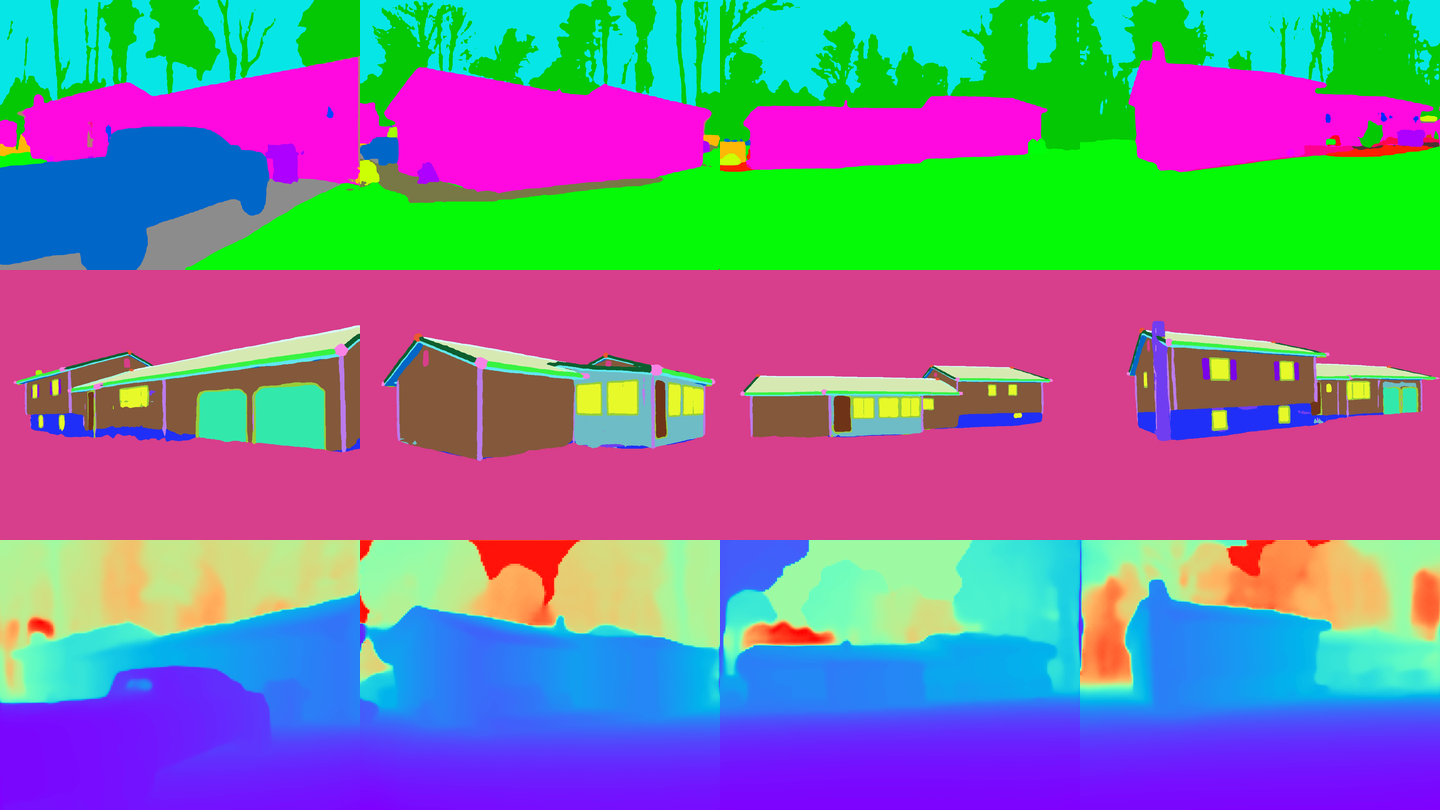

In [55]:
# for ki in range(len(human_entry['gestalt'])):
#     plt.figure()
#     plt.imshow(human_entry['gestalt'][ki])
#     plt.title('Gestalt segmentation')

# plt.figure()
# depth = np.array(human_entry['depthcm'][0])/100.
# depth[depth>20] = 0
# depth = depth/depth.max()
# plt.title('Monodepth')
# plt.imshow(depth, cmap='rainbow')

vis.visualize_order_images(human_entry)

In [56]:
col_cams = [hoho.Rt_to_eye_target(human_entry['ade20k'][0], to_K(*human_entry['cameras'][1].params), quaternion_to_rotation_matrix(colmap_img.qvec), colmap_img.tvec) for colmap_img in human_entry['images'].values()]
eye, target, up, fov = col_cams[0]

cameras, images, points3D = human_entry['cameras'], human_entry['images'], human_entry['points3d']
colmap_cameras_tf = list(human_entry['images'].keys())

xyz = np.stack([p.xyz for p in points3D.values()])
color = np.stack([p.rgb for p in points3D.values()])
pcd = trimesh.Scene([trimesh.PointCloud(vertices=xyz, colors=color)])

V, E = human_entry['wf_vertices'], human_entry['wf_edges']
wf = vis.show_wf(human_entry)

ax = [line((0,0,0), 1200*b, c=255*b, radius=15) for b in np.eye(3)]

u = trimesh.Trimesh(vertices=human_entry['mesh_vertices'] , faces=human_entry['mesh_faces'][:, 1:])

cams = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6) for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[human_entry[k] for k in 'ade20k K R t'.split()]))])
cams_colmap = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6, c=(0,0,255)) for eye, target, up, fov in col_cams])

gestalt_camcet = np.stack([eye for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[human_entry[k] for k in 'ade20k K R t'.split()]))])
col_camcet = np.stack([eye for eye, target, up, fov in col_cams])
gestalt_to_colmap_cams = [colmap_cameras_tf[np.argmin(((gcam - col_camcet)**2).sum(1)**0.5)] for gcam in gestalt_camcet]
broken_cams = np.array([np.min(((gcam - col_camcet)**2).sum(1)**0.5) for gcam in gestalt_camcet]) > 300

trimesh.Scene([
        # u,
        # ax,
        cams,
        cams_colmap,
        pcd,
        *wf
    ]).show()

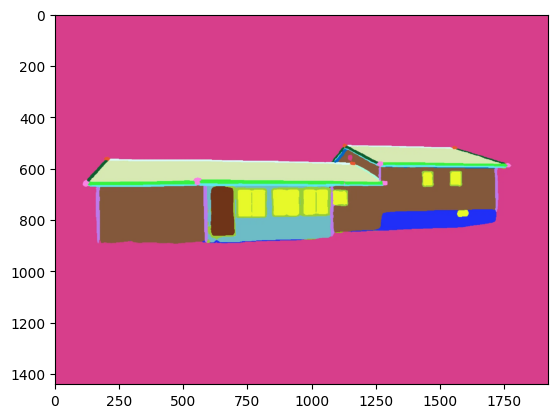

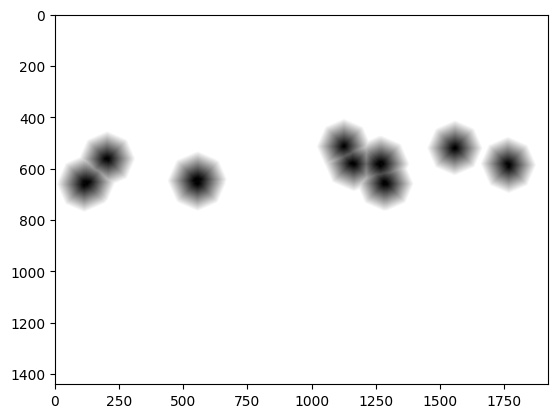

In [57]:
ki = 2
clr_th = 2.5

gest = np.array(human_entry['gestalt'][ki])
apex_color = np.array(gestalt_color_mapping['apex'])
apex_mask = cv2.inRange(gest,  apex_color-clr_th, apex_color+clr_th)
eave_end_color = np.array(gestalt_color_mapping['eave_end_point'])
eave_end_mask = cv2.inRange(gest,  eave_end_color-clr_th, eave_end_color+clr_th)
vert_mask = apex_mask + eave_end_mask
# vert_mask = cv2.dilate(vert_mask, np.ones((5,5)), iterations = 7)
vert_mask = (vert_mask > 0).astype(np.uint8)


dist = cv2.distanceTransform(1-vert_mask, cv2.DIST_L2, 3)
dist[dist > 100] = 100
ndist = np.zeros_like(dist)
ndist = cv2.normalize(dist, ndist, 0, 1.0, cv2.NORM_MINMAX)

plt.imshow(np.array(human_entry['gestalt'][ki]))
plt.figure()
plt.imshow(ndist, cmap='gray')


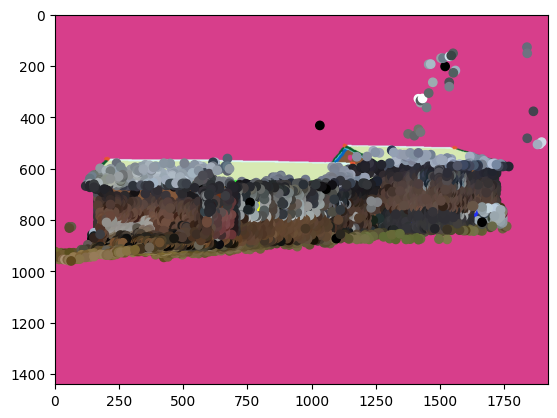

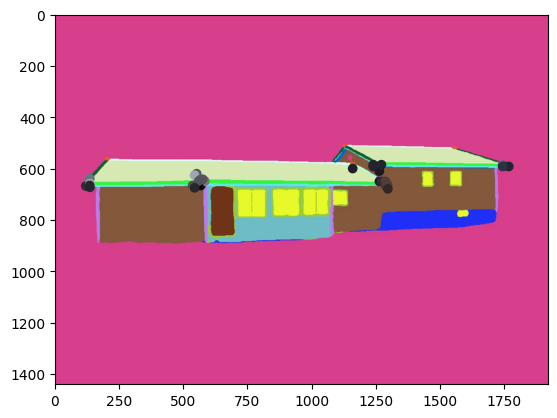

In [58]:
device = 'cuda:0'
height = cameras[1].height
width = cameras[1].width
N = len(gestalt_to_colmap_cams)
cki = gestalt_to_colmap_cams[ki]

# K, R, T = human_entry['K'], human_entry['R'], human_entry['t']
K = to_K(*human_entry['cameras'][1].params)[None].repeat(N, 0)
R = np.stack([quaternion_to_rotation_matrix(human_entry['images'][gestalt_to_colmap_cams[ind]].qvec) for ind in range(N)])
T = np.stack([human_entry['images'][gestalt_to_colmap_cams[ind]].tvec for ind in range(N)])

R = np.linalg.inv(R)
image_size=torch.Tensor([height, width]).repeat(N, 1)

verts = torch.from_numpy(xyz.astype(np.float32)).to(device)
clrs = torch.from_numpy(color.astype(np.float32)).to(device)
point_cloud = Pointclouds(points=[verts], features=[clrs])

pyt_cameras = PerspectiveCameras(device=device, R=R, T=T, in_ndc=False, focal_length=K[:, 0, :1], principal_point=K[:, :2, 2], image_size=image_size)
raster_settings = PointsRasterizationSettings(
    image_size=[height, width], 
    radius = 0.02,
    points_per_pixel = 10
)

renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=pyt_cameras[ki], raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)
images = renderer(point_cloud)

in_this_image = np.array([cki in p.image_ids for p in points3D.values()])
uv = torch.round(pyt_cameras[ki].transform_points(verts)[:, :2]).cpu().numpy().astype(int)
uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height) * in_this_image
uv = uv[uv_inl]
uv_clrs = clrs[uv_inl].cpu().numpy() / 255

vert_inl = dist[uv[:,1], uv[:,0]] < 20
vert_uv = uv[vert_inl]
vert_uv_clrs = uv_clrs[vert_inl]

plt.figure()
plt.imshow(gest)
# plt.imshow(images[0].cpu().numpy()[::-1,::-1]/255)
plt.scatter(uv[:, 0], uv[:, 1], c=uv_clrs)

plt.figure()
plt.imshow(gest)
plt.scatter(vert_uv[:, 0], vert_uv[:, 1], c=vert_uv_clrs)
# plt.scatter(uv[:, 0], uv[:, 1], c=uv_clrs)


In [59]:
# pcd_ours = trimesh.Scene([trimesh.PointCloud(vertices=xyz[selected_points], colors=color[selected_points])])
pcd_ours = trimesh.Scene([line(pnt, (pnt + [10, 0, 0]), radius=10, c=[0,0,255]) for pnt in xyz[selected_points][dense_pnts]])
# pcd_ours = trimesh.Scene([line(pnt, (pnt + [10, 0, 0]), radius=10, c=[0,0,255]) for pnt in xyz[selected_points]])
# centers_ours = trimesh.Scene([trimesh.PointCloud(vertices=centers)])
centers_ours = trimesh.Scene([line(pnt, (pnt + [20, 0, 0]), radius=20) for pnt in centers])
# centers_ours = trimesh.Scene([line(pnt, (pnt + [20, 0, 0]), radius=20) for pnt in xyz[center_inds]])
trimesh.Scene([
        # u,
        # ax,
        cams,
        cams_colmap,
        pcd_ours,
        centers_ours,
        *wf
    ]).show()

NameError: name 'selected_points' is not defined

In [21]:
self = GeomSolver()
vertices = self.solve(entry)
edges = self.process_edges()

In [82]:

# centers_apex, assigned_apex = self.cluster_points(['apex'])
# centers_eave, assigned_eave = self.cluster_points(['eave_end_point'])
# centers = np.concatenate((centers_apex, centers_eave))
# assigned_points = assigned_apex + assigned_eave

# is_apex = np.zeros((centers.shape[0], )).astype(int)
# is_apex[:centers_apex.shape[0]] = 1

vis_apexes = trimesh.Scene([line(pnt, (pnt + [20, 0, 0]), radius=20) for pnt in self.vertices[self.is_apex == 1]])
vis_eaves = trimesh.Scene([line(pnt, (pnt + [20, 0, 0]), radius=20, c=[0,0,255]) for pnt in self.vertices[self.is_apex == 0]])
trimesh.Scene([
        # u,
        # ax,
        cams,
        cams_colmap,
        vis_apexes,
        vis_eaves,
        *wf
    ]).show()

In [72]:
image_ids = np.array([p.id for p in self.points3D.values()])
center_visibility = [set(np.concatenate([self.points3D[image_ids[pind]].image_ids for pind in ass_item])) for ass_item in self.assigned_points]
center_visibility

[{5, 6},
 {2, 3},
 {4, 5, 6},
 {5, 6},
 {1, 2},
 {4, 5, 6},
 {1, 2, 3},
 {2, 3},
 {1, 2},
 {7, 8, 9}]

In [73]:
edges

[]

In [89]:
self = solver
pyt_centers = torch.from_numpy(self.vertices).to(self.device)
N = len(self.gests)
clr_th = 2.5

edge_dists = []
uvs = []
edge_types = {0 : ['eave'], 1 : ['rake', 'valley'], 2 : ['ridge']}
for ki in range(N):
    gest = self.gests[ki]
    edge_masks = {}
    per_type_dists = {}
    for etype in edge_types:
        edge_mask = 0
        for edge_class in edge_types[etype]:
            edge_color = np.array(gestalt_color_mapping[edge_class])
            mask = cv2.morphologyEx(cv2.inRange(gest,
                                                edge_color-clr_th,
                                                edge_color+clr_th),
                                    cv2.MORPH_DILATE, np.ones((3, 3)))
            edge_mask += mask
        edge_mask = (edge_mask > 0).astype(np.uint8)
        edge_masks[etype] = edge_mask
        dist = cv2.distanceTransform(1-edge_mask, cv2.DIST_L2, 3)
        per_type_dists[etype] = dist
    edge_dists.append(per_type_dists)
        
    uv = torch.round(self.pyt_cameras[ki].transform_points(pyt_centers)[:, :2]).cpu().numpy().astype(int)
    uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < self.width) * (uv[:, 1] < self.height)
    uv = uv[uv_inl]
    uvs.append(uv)
# ndist = np.zeros_like(dist)
# ndist = cv2.normalize(dist, ndist, 0, 1.0, cv2.NORM_MINMAX)
# plt.imshow(ndist, cmap='gray')
# plt.imshow(edge_dists[ki], cmap='gray')
# plt.scatter(uv[:, 0], uv[:, 1])
edges = []
thresholds_min_mean = {0 : [5, 7], 1 : [9, 25], 2: [30, 1000]}
for i in range(pyt_centers.shape[0]):
    for j in range(i+1, pyt_centers.shape[0]):
        # if not (i == 0 and j == 3):
        #     continue
        # if len(center_visibility[j].intersection(center_visibility[i])) == 0:
        #     continue
        # if is_apex[i] + is_apex[j] != 0:
        #     continue
        etype = (self.is_apex[i] + self.is_apex[j])
        # if etype != 1:
        #     continue

        points_inter = pyt_centers[i][None] + torch.linspace(0, 1, 20)[:, None].to(self.device) * (pyt_centers[j][None] - pyt_centers[i][None])
        min_mean_dist = 1000
        all_dists = []
        best_ki = -1
        best_uvi = -1
        for ki in range(N):
            cki = self.gestalt_to_colmap_cams[ki]
            
            if not ( (cki in center_visibility[i]) or (cki in center_visibility[j]) ):
                continue
        
            uvi = torch.round(self.pyt_cameras[ki].transform_points(points_inter)[:, :2]).cpu().numpy().astype(int)
            if (uvi <= 0).any() or (uvi[:,0] >= self.width).any() or (uvi[:,1] >= self.height).any():
                continue
            mean_dist = edge_dists[ki][etype][uvi[:,1], uvi[:,0]].mean()
            all_dists.append(mean_dist)
            if mean_dist < min_mean_dist:
                min_mean_dist = mean_dist
                best_ki = ki
                best_uvi = uvi
                
            # fig = plt.figure()
            # fig.suptitle("{}, {}, {}".format(mean_dist, i, j))
            # edge_vis = edge_dists[ki][etype]
            # edge_vis[edge_vis > 50] = 50
            # # plt.imshow(edge_vis, cmap='gray')
            # plt.imshow(self.gests[ki])
            # # plt.scatter(uv[inds, 0], uv[inds, 1])
            # plt.scatter(uvi[:, 0], uvi[:, 1])

        if best_ki == -1:
            continue
        ths = thresholds_min_mean[etype]
        if min_mean_dist < ths[0] and np.mean(all_dists) < ths[1]:
            # print(i,j,all_dists)
            edges.append([i,j])
        # fig = plt.figure()
        # fig.suptitle("{}, {}, {}".format(min_mean_dist, i, j))
        # edge_vis = edge_dists[best_ki][etype]
        # edge_vis[edge_vis > 50] = 50
        # # plt.imshow(edge_vis, cmap='gray')
        # plt.imshow(self.gests[best_ki])
        # # plt.scatter(uv[inds, 0], uv[inds, 1])
        # plt.scatter(best_uvi[:, 0], best_uvi[:, 1])



In [90]:
# print(edges)
plot_estimate_and_gt(   vertices, 
                        edges,         
                        np.array(entry['wf_vertices']),
                        np.array(entry['wf_edges']))

In [ ]:
# gestalt_to_colmap_cams
points3D[center_inds[6]].image_ids
np.array([points3D[pind].image_ids for pind in center_inds])
center_inds

In [ ]:
for ki in range(N):
    plt.figure()
    gest = np.array(human_entry['gestalt'][ki])
    plt.imshow(gest)

    cki = gestalt_to_colmap_cams[ki]
    in_this_image = np.array([cki in points3D[image_ids[pind]].image_ids for pind in center_inds])

    uv = torch.round(pyt_cameras[ki].transform_points(pyt_centers)[:, :2]).cpu().numpy().astype(int)
    uv = uv[in_this_image]
    uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height)
    uv = uv[uv_inl]
    plt.scatter(uv[:, 0], uv[:, 1])


In [ ]:
# TODO: separate for eave_end_point and apex

In [ ]:
# world_to_cam = np.eye(4)[None].repeat(3, 0)
# world_to_cam[:, :3, :3] = R
# world_to_cam[:, :3, 3] = T
# cam_to_world =  np.linalg.inv(world_to_cam)